# Analise de configuração da rede MLP com a base Mammography

Leitura da base de dados

In [6]:
import pandas as pd

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler

from extensions import *
from IPython.display import display
from plot_util import *
from train_util import *

NOTEBOOK = True

print('read database')
db_file = 'database.csv'
db_frame = pd.read_csv(db_file, header=None)
print(f'instances: {db_frame.shape[0]}')
print()

read database
instances: 11183



Separação de instâncias positivas e negativas

In [2]:
print('split negatives and positives')
negs_frame = db_frame[db_frame.iloc[:, -1] == 0]
poss_frame = db_frame[db_frame.iloc[:, -1] == 1]
print('shuffle negatives and positives')
negs_frame = negs_frame.sample(frac=1).reset_index(drop=True)
poss_frame = poss_frame.sample(frac=1).reset_index(drop=True)
print(f'neg: {negs_frame.shape[0]}, pos: {poss_frame.shape[0]}')
print()

split negatives and positives
shuffle negatives and positives
neg: 10923, pos: 260



Divisão das instâncias usando k-fold cross validation com 10 folds

In [3]:
k = 10
print(f'create k={k} folds')
negs_frame_folds = np.array_split(negs_frame, k)
poss_frame_folds = np.array_split(poss_frame, k)
print('merge and shuffle individual folds')
frame_folds = [pd.concat([negs_frame_folds[i], poss_frame_folds[i]], axis=0, join='outer') for i in range(k)]
frame_folds = [ff.sample(frac=1).reset_index(drop=True) for ff in frame_folds]
print(f'split instances and classes and transform in numpy arrays')
base_folds = [(ff.iloc[:, :-1].as_matrix(), ff.iloc[:, -1].as_matrix()) for ff in frame_folds]
print('\n'.join(f'{i}: n={negs_frame_folds[i].shape[0]} p={poss_frame_folds[i].shape[0]} t={frame_folds[i].shape[0]}'
                for i in range(k)))
print()

create k=10 folds
merge and shuffle individual folds
split instances and classes and transform in numpy arrays
0: n=1093 p=26 t=1119
1: n=1093 p=26 t=1119
2: n=1093 p=26 t=1119
3: n=1092 p=26 t=1118
4: n=1092 p=26 t=1118
5: n=1092 p=26 t=1118
6: n=1092 p=26 t=1118
7: n=1092 p=26 t=1118
8: n=1092 p=26 t=1118
9: n=1092 p=26 t=1118



Resample da amostra usando algoritmos de under sampling e over sampling, os algoritmos usados foram
RandomOverSampler, SMOTE, ClusterCentroids (K-Means) e RandomUnderSampler

Os algoritmos são aplicados individualmente em cada fold para que não haja sobreposição dos dados em diferentes folds

In [4]:
print('resample folds')
samplers = {
    'r-over': RandomOverSampler(), 'smote': SMOTE(),
    'k-means': ClusterCentroids(), 'r-under': RandomUnderSampler()
}
samples_folds = {name: [sampler.fit_sample(*fold) for fold in base_folds] for name, sampler in samplers.items()}
for name, sample_folds in samples_folds.items():
    print('sampler %s folds: %s' % (name, [len(fold[0]) for fold in sample_folds]))
print()

resample folds
sampler r-over folds: [2186, 2186, 2186, 2184, 2184, 2184, 2184, 2184, 2184, 2184]
sampler smote folds: [2186, 2186, 2186, 2184, 2184, 2184, 2184, 2184, 2184, 2184]
sampler k-means folds: [52, 52, 52, 52, 52, 52, 52, 52, 52, 52]
sampler r-under folds: [52, 52, 52, 52, 52, 52, 52, 52, 52, 52]



Configurações base, a partir destas, cada atributo será testado independentemente

In [7]:
model_class = ModMLPClassifier

base_configurations = [
    {
        'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,),
        'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200,

        'train_folds': k - 1,  # number of training folds (the last will be choose to validate)
        'max_fail': 3  # max number of consecutive fails in validation score reduction
    },
    {
        'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,),
        'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'max_iter': 800,

        'train_folds': k - 1,  # number of training folds (the last will be choose to validate)
        'max_fail': 3  # max number of consecutive fails in validation score reduction
    },
    {
        'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,),
        'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'max_iter': 3200,

        'train_folds': k - 1,  # number of training folds (the last will be choose to validate)
        'max_fail': 3  # max number of consecutive fails in validation score reduction
    }
]
print('base configurations:')
if NOTEBOOK:
    display(pd.DataFrame(base_configurations))
else:
    print(pd.DataFrame(base_configurations).to_string())

base configurations:


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds
0,logistic,True,"(8,)",invscaling,0.0100,3,200,sgd,9
1,logistic,True,"(16,)",adaptive,0.0010,3,800,sgd,9
2,logistic,True,"(32,)",constant,0.0001,3,3200,sgd,9


Atributos principais a seram variados e seus valores

In [10]:
variations = [
    ('learning_rate_init', [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]),
    ('hidden_layer_sizes', [(2 ** x,) for x in range(1, 8)]),
    ('max_iter', [200, 400, 800, 1600, 3200, 6400]),
    ('learning_rate', ['constant', 'invscaling', 'adaptive']),
    ('activation', ['relu', 'logistic', 'tanh'])
]

if NOTEBOOK:
    display(pd.DataFrame(variations))
else:
    print(pd.DataFrame(variations).to_string())

,0,1
0,learning_rate_init,"[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]"
1,hidden_layer_sizes,"[(2,), (4,), (8,), (16,), (32,), (64,), (128,)]"
2,max_iter,"[200, 400, 800, 1600, 3200, 6400]"
3,learning_rate,"[constant, invscaling, adaptive]"
4,activation,"[relu, logistic, tanh]"


Testes individuais com as diferentes bases geradas com os algoritmos de sampling
* K-Means

optimize model configuration for r-over with configuration range of 3
variation 0 -> learning_rate_init
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
11,logistic,True,"(16,)",adaptive,0.0500,3,800,sgd,9,0.890636,0.109364,0.928784
17,logistic,True,"(32,)",constant,0.0500,3,3200,sgd,9,0.891620,0.108380,0.925396
16,logistic,True,"(32,)",constant,0.0100,3,3200,sgd,9,0.889560,0.110440,0.924160
5,logistic,True,"(8,)",invscaling,0.0500,3,200,sgd,9,0.868815,0.131185,0.921509
10,logistic,True,"(16,)",adaptive,0.0100,3,800,sgd,9,0.883033,0.116967,0.921451
9,logistic,True,"(16,)",adaptive,0.0050,3,800,sgd,9,0.879099,0.120901,0.920393
15,logistic,True,"(32,)",constant,0.0050,3,3200,sgd,9,0.895373,0.104627,0.919209
4,logistic,True,"(8,)",invscaling,0.0100,3,200,sgd,9,0.803810,0.196190,0.913536
8,logistic,True,"(16,)",adaptive,0.0010,3,800,sgd,9,0.857638,0.142362,0.912169
7,logistic,True,"(16,)",adaptive,0.0005,3,800,sgd,9,0.844843,0.155157,0.911038


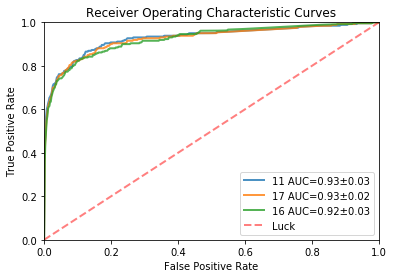


variation 1 -> hidden_layer_sizes
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
0,logistic,True,"(2,)",adaptive,0.05,3,800,sgd,9,0.913706,0.086294,0.941305
1,logistic,True,"(4,)",adaptive,0.05,3,800,sgd,9,0.913167,0.086833,0.938705
7,logistic,True,"(2,)",constant,0.05,3,3200,sgd,9,0.912721,0.087279,0.938638
9,logistic,True,"(8,)",constant,0.05,3,3200,sgd,9,0.906640,0.093360,0.934146
8,logistic,True,"(4,)",constant,0.05,3,3200,sgd,9,0.900470,0.099530,0.933822
2,logistic,True,"(8,)",adaptive,0.05,3,800,sgd,9,0.897159,0.102841,0.933556
3,logistic,True,"(16,)",adaptive,0.05,3,800,sgd,9,0.896894,0.103106,0.933445
4,logistic,True,"(32,)",adaptive,0.05,3,800,sgd,9,0.898859,0.101141,0.930839
10,logistic,True,"(16,)",constant,0.05,3,3200,sgd,9,0.890811,0.109189,0.930745
11,logistic,True,"(32,)",constant,0.05,3,3200,sgd,9,0.892332,0.107668,0.926974


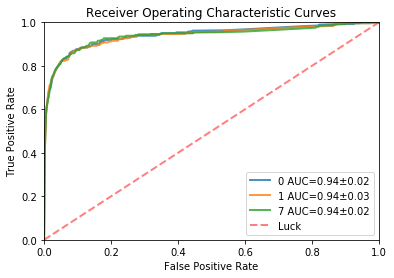


variation 2 -> max_iter
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
12,logistic,True,"(2,)",constant,0.05,3,200,sgd,9,0.916297,0.083703,0.943276
4,logistic,True,"(2,)",adaptive,0.05,3,3200,sgd,9,0.906370,0.093630,0.942469
5,logistic,True,"(2,)",adaptive,0.05,3,6400,sgd,9,0.907445,0.092555,0.940978
2,logistic,True,"(2,)",adaptive,0.05,3,800,sgd,9,0.911737,0.088263,0.940823
3,logistic,True,"(2,)",adaptive,0.05,3,1600,sgd,9,0.910128,0.089872,0.940379
0,logistic,True,"(2,)",adaptive,0.05,3,200,sgd,9,0.919071,0.080929,0.940211
16,logistic,True,"(2,)",constant,0.05,3,3200,sgd,9,0.908697,0.091303,0.938719
10,logistic,True,"(4,)",adaptive,0.05,3,3200,sgd,9,0.909053,0.090947,0.938258
8,logistic,True,"(4,)",adaptive,0.05,3,800,sgd,9,0.909948,0.090052,0.937812
6,logistic,True,"(4,)",adaptive,0.05,3,200,sgd,9,0.907623,0.092377,0.937640


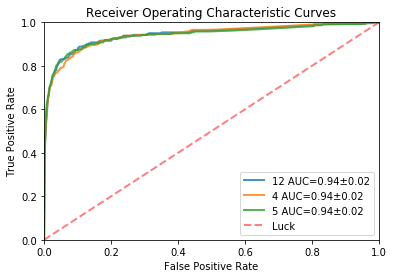


variation 3 -> learning_rate
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 6400, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
6,logistic,True,"(2,)",constant,0.05,3,6400,sgd,9,0.910397,0.089603,0.942255
8,logistic,True,"(2,)",adaptive,0.05,3,6400,sgd,9,0.919606,0.080394,0.941088
0,logistic,True,"(2,)",constant,0.05,3,200,sgd,9,0.912273,0.087727,0.938732
2,logistic,True,"(2,)",adaptive,0.05,3,200,sgd,9,0.910039,0.089961,0.937778
3,logistic,True,"(2,)",constant,0.05,3,3200,sgd,9,0.904850,0.095150,0.934608
5,logistic,True,"(2,)",adaptive,0.05,3,3200,sgd,9,0.913169,0.086831,0.934220
4,logistic,True,"(2,)",invscaling,0.05,3,3200,sgd,9,0.846733,0.153267,0.919415
1,logistic,True,"(2,)",invscaling,0.05,3,200,sgd,9,0.856391,0.143609,0.919333
7,logistic,True,"(2,)",invscaling,0.05,3,6400,sgd,9,0.859158,0.140842,0.918621


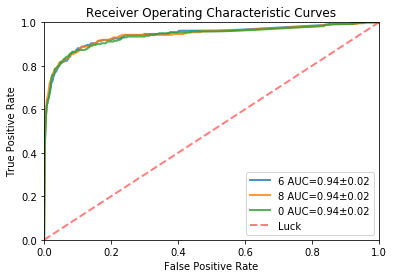


variation 4 -> activation
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 6400, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 6400, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
5,tanh,True,"(2,)",adaptive,0.05,3,6400,sgd,9,0.925151,0.074849,0.944337
2,tanh,True,"(2,)",constant,0.05,3,6400,sgd,9,0.932393,0.067607,0.943165
4,logistic,True,"(2,)",adaptive,0.05,3,6400,sgd,9,0.918982,0.081018,0.942943
8,tanh,True,"(2,)",constant,0.05,3,200,sgd,9,0.928369,0.071631,0.941288
3,relu,True,"(2,)",adaptive,0.05,3,6400,sgd,9,0.929268,0.070732,0.939358
7,logistic,True,"(2,)",constant,0.05,3,200,sgd,9,0.908250,0.091750,0.937094
6,relu,True,"(2,)",constant,0.05,3,200,sgd,9,0.921572,0.078428,0.936446
0,relu,True,"(2,)",constant,0.05,3,6400,sgd,9,0.931415,0.068585,0.934867
1,logistic,True,"(2,)",constant,0.05,3,6400,sgd,9,0.907712,0.092288,0.932898


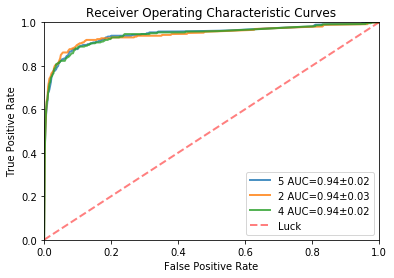


best configuration


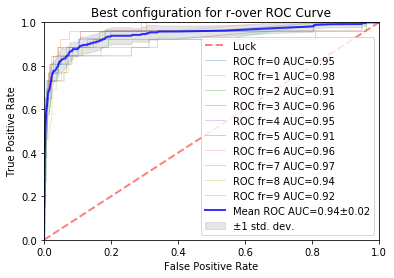

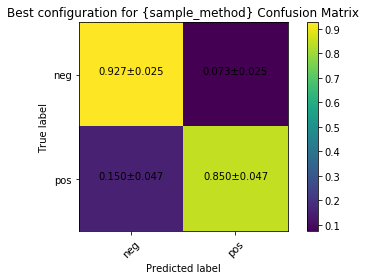

testing overfiting (increased verbose)
run 1 of 1, fold 1 of 10
run 1 of 1, fold 2 of 10
run 1 of 1, fold 3 of 10
run 1 of 1, fold 4 of 10
run 1 of 1, fold 5 of 10
run 1 of 1, fold 6 of 10
run 1 of 1, fold 7 of 10
run 1 of 1, fold 8 of 10
run 1 of 1, fold 9 of 10
run 1 of 1, fold 10 of 10


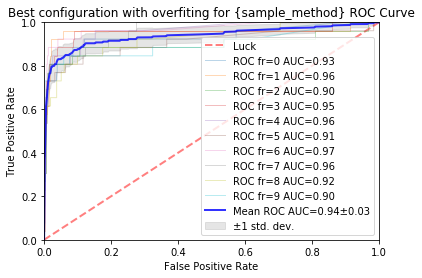

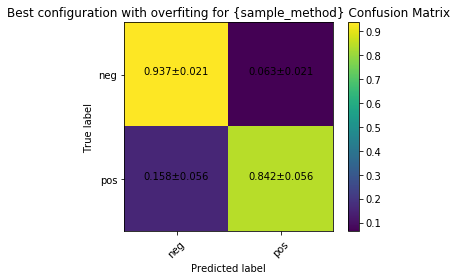




optimize model configuration for smote with configuration range of 3
variation 0 -> learning_rate_init
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
11,logistic,True,"(16,)",adaptive,0.0500,3,800,sgd,9,0.903782,0.096218,0.931475
17,logistic,True,"(32,)",constant,0.0500,3,3200,sgd,9,0.904408,0.095592,0.928228
9,logistic,True,"(16,)",adaptive,0.0050,3,800,sgd,9,0.881875,0.118125,0.923372
5,logistic,True,"(8,)",invscaling,0.0500,3,200,sgd,9,0.874720,0.125280,0.920259
10,logistic,True,"(16,)",adaptive,0.0100,3,800,sgd,9,0.884731,0.115269,0.919705
16,logistic,True,"(32,)",constant,0.0100,3,3200,sgd,9,0.893497,0.106503,0.919444
15,logistic,True,"(32,)",constant,0.0050,3,3200,sgd,9,0.895644,0.104356,0.917396
8,logistic,True,"(16,)",adaptive,0.0010,3,800,sgd,9,0.865060,0.134940,0.916264
14,logistic,True,"(32,)",constant,0.0010,3,3200,sgd,9,0.880709,0.119291,0.915141
12,logistic,True,"(32,)",constant,0.0001,3,3200,sgd,9,0.868190,0.131810,0.913772


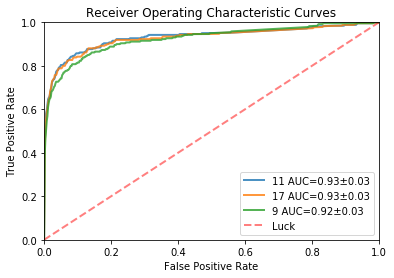


variation 1 -> hidden_layer_sizes
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.005, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
0,logistic,True,"(2,)",adaptive,0.050,3,800,sgd,9,0.919068,0.080932,0.938023
8,logistic,True,"(4,)",constant,0.050,3,3200,sgd,9,0.917639,0.082361,0.936343
1,logistic,True,"(4,)",adaptive,0.050,3,800,sgd,9,0.911919,0.088081,0.935652
2,logistic,True,"(8,)",adaptive,0.050,3,800,sgd,9,0.910219,0.089781,0.935454
7,logistic,True,"(2,)",constant,0.050,3,3200,sgd,9,0.914959,0.085041,0.934401
9,logistic,True,"(8,)",constant,0.050,3,3200,sgd,9,0.903243,0.096757,0.932445
3,logistic,True,"(16,)",adaptive,0.050,3,800,sgd,9,0.907359,0.092641,0.931453
11,logistic,True,"(32,)",constant,0.050,3,3200,sgd,9,0.901902,0.098098,0.930489
10,logistic,True,"(16,)",constant,0.050,3,3200,sgd,9,0.902439,0.097561,0.929537
4,logistic,True,"(32,)",adaptive,0.050,3,800,sgd,9,0.896896,0.103104,0.928410


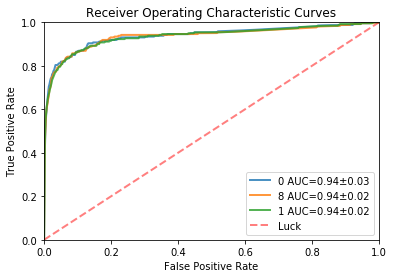


variation 2 -> max_iter
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
3,logistic,True,"(2,)",adaptive,0.05,3,1600,sgd,9,0.921662,0.078338,0.940705
7,logistic,True,"(4,)",constant,0.05,3,400,sgd,9,0.914958,0.085042,0.940292
1,logistic,True,"(2,)",adaptive,0.05,3,400,sgd,9,0.930428,0.069572,0.939592
14,logistic,True,"(4,)",adaptive,0.05,3,800,sgd,9,0.918265,0.081735,0.938769
8,logistic,True,"(4,)",constant,0.05,3,800,sgd,9,0.908517,0.091483,0.938637
0,logistic,True,"(2,)",adaptive,0.05,3,200,sgd,9,0.916835,0.083165,0.938428
16,logistic,True,"(4,)",adaptive,0.05,3,3200,sgd,9,0.919159,0.080841,0.938087
11,logistic,True,"(4,)",constant,0.05,3,6400,sgd,9,0.912901,0.087099,0.937971
4,logistic,True,"(2,)",adaptive,0.05,3,3200,sgd,9,0.916386,0.083614,0.937941
2,logistic,True,"(2,)",adaptive,0.05,3,800,sgd,9,0.919788,0.080212,0.937347


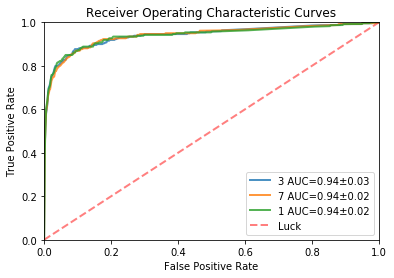


variation 3 -> learning_rate
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 1600, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 400, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 400, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
5,logistic,True,"(4,)",adaptive,0.05,3,400,sgd,9,0.916925,0.083075,0.940171
3,logistic,True,"(4,)",constant,0.05,3,400,sgd,9,0.914868,0.085132,0.938218
6,logistic,True,"(2,)",constant,0.05,3,400,sgd,9,0.916299,0.083701,0.938167
2,logistic,True,"(2,)",adaptive,0.05,3,1600,sgd,9,0.920500,0.079500,0.937245
8,logistic,True,"(2,)",adaptive,0.05,3,400,sgd,9,0.919697,0.080303,0.935449
0,logistic,True,"(2,)",constant,0.05,3,1600,sgd,9,0.923810,0.076190,0.934825
7,logistic,True,"(2,)",invscaling,0.05,3,400,sgd,9,0.853170,0.146830,0.922250
4,logistic,True,"(4,)",invscaling,0.05,3,400,sgd,9,0.866404,0.133596,0.919866
1,logistic,True,"(2,)",invscaling,0.05,3,1600,sgd,9,0.853078,0.146922,0.917303


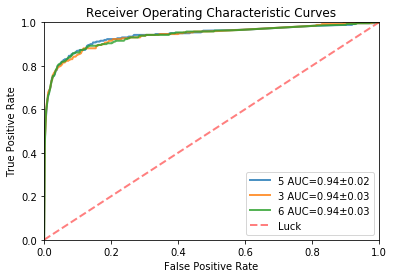


variation 4 -> activation
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 400, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 400, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 400, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
5,tanh,True,"(4,)",constant,0.05,3,400,sgd,9,0.942232,0.057768,0.946640
2,tanh,True,"(4,)",adaptive,0.05,3,400,sgd,9,0.937494,0.062506,0.944756
8,tanh,True,"(2,)",constant,0.05,3,400,sgd,9,0.937404,0.062596,0.943900
3,relu,True,"(4,)",constant,0.05,3,400,sgd,9,0.939996,0.060004,0.942188
0,relu,True,"(4,)",adaptive,0.05,3,400,sgd,9,0.933646,0.066354,0.940981
7,logistic,True,"(2,)",constant,0.05,3,400,sgd,9,0.920326,0.079674,0.939484
1,logistic,True,"(4,)",adaptive,0.05,3,400,sgd,9,0.908875,0.091125,0.936434
4,logistic,True,"(4,)",constant,0.05,3,400,sgd,9,0.909503,0.090497,0.935391
6,relu,True,"(2,)",constant,0.05,3,400,sgd,9,0.926939,0.073061,0.935066


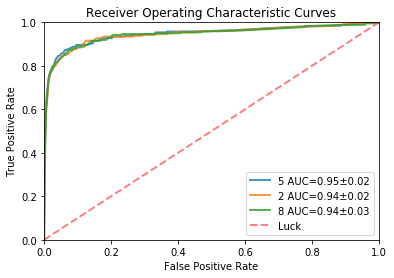


best configuration


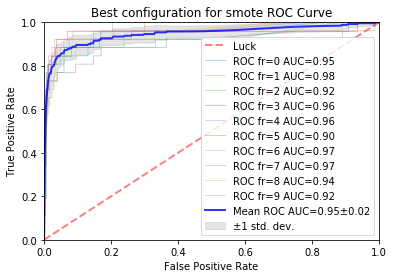

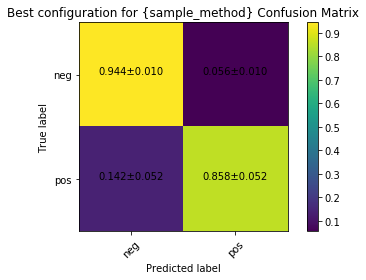

testing overfiting (increased verbose)
run 1 of 1, fold 1 of 10
run 1 of 1, fold 2 of 10
run 1 of 1, fold 3 of 10
run 1 of 1, fold 4 of 10
run 1 of 1, fold 5 of 10
run 1 of 1, fold 6 of 10
run 1 of 1, fold 7 of 10
run 1 of 1, fold 8 of 10
run 1 of 1, fold 9 of 10
run 1 of 1, fold 10 of 10


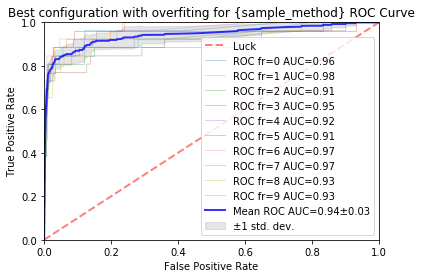

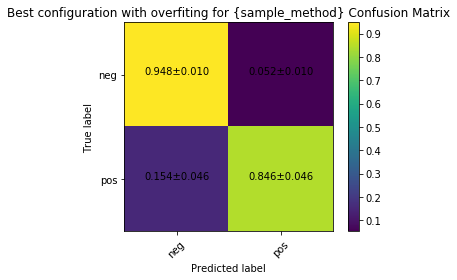




optimize model configuration for k-means with configuration range of 3
variation 0 -> learning_rate_init
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
10,logistic,True,"(16,)",adaptive,0.0100,3,800,sgd,9,0.827205,0.172795,0.906175
17,logistic,True,"(32,)",constant,0.0500,3,3200,sgd,9,0.880082,0.119918,0.900305
11,logistic,True,"(16,)",adaptive,0.0500,3,800,sgd,9,0.871493,0.128507,0.898706
16,logistic,True,"(32,)",constant,0.0100,3,3200,sgd,9,0.799483,0.200517,0.850879
9,logistic,True,"(16,)",adaptive,0.0050,3,800,sgd,9,0.565981,0.434019,0.749955
5,logistic,True,"(8,)",invscaling,0.0500,3,200,sgd,9,0.885810,0.114190,0.672065
1,logistic,True,"(8,)",invscaling,0.0005,3,200,sgd,9,0.369350,0.630650,0.609542
4,logistic,True,"(8,)",invscaling,0.0100,3,200,sgd,9,0.615560,0.384440,0.583003
6,logistic,True,"(16,)",adaptive,0.0001,3,800,sgd,9,0.616084,0.383916,0.560999
3,logistic,True,"(8,)",invscaling,0.0050,3,200,sgd,9,0.377096,0.622904,0.545200


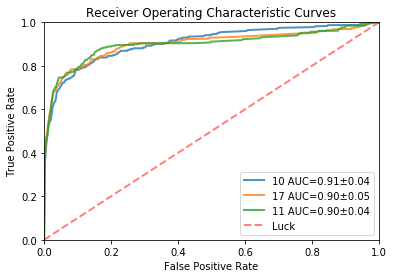


variation 1 -> hidden_layer_sizes
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
15,logistic,True,"(4,)",adaptive,0.05,3,800,sgd,9,0.847450,0.152550,0.907548
5,logistic,True,"(64,)",adaptive,0.01,3,800,sgd,9,0.892256,0.107744,0.904782
20,logistic,True,"(128,)",adaptive,0.05,3,800,sgd,9,0.894933,0.105067,0.901167
18,logistic,True,"(32,)",adaptive,0.05,3,800,sgd,9,0.886968,0.113032,0.900223
13,logistic,True,"(128,)",constant,0.05,3,3200,sgd,9,0.917822,0.082178,0.900189
17,logistic,True,"(16,)",adaptive,0.05,3,800,sgd,9,0.830167,0.169833,0.899066
12,logistic,True,"(64,)",constant,0.05,3,3200,sgd,9,0.886612,0.113388,0.898551
9,logistic,True,"(8,)",constant,0.05,3,3200,sgd,9,0.894214,0.105786,0.896636
19,logistic,True,"(64,)",adaptive,0.05,3,800,sgd,9,0.880973,0.119027,0.895631
6,logistic,True,"(128,)",adaptive,0.01,3,800,sgd,9,0.874710,0.125290,0.893933


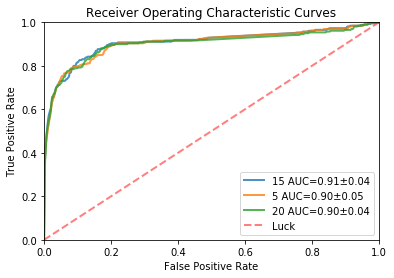


variation 2 -> max_iter
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
1,logistic,True,"(4,)",adaptive,0.05,3,400,sgd,9,0.760685,0.239315,0.904751
8,logistic,True,"(64,)",adaptive,0.01,3,800,sgd,9,0.905754,0.094246,0.899643
10,logistic,True,"(64,)",adaptive,0.01,3,3200,sgd,9,0.864076,0.135924,0.899566
16,logistic,True,"(128,)",adaptive,0.05,3,3200,sgd,9,0.878206,0.121794,0.899364
12,logistic,True,"(128,)",adaptive,0.05,3,200,sgd,9,0.903598,0.096402,0.899336
15,logistic,True,"(128,)",adaptive,0.05,3,1600,sgd,9,0.891973,0.108027,0.899061
14,logistic,True,"(128,)",adaptive,0.05,3,800,sgd,9,0.884380,0.115620,0.899026
13,logistic,True,"(128,)",adaptive,0.05,3,400,sgd,9,0.876952,0.123048,0.898727
9,logistic,True,"(64,)",adaptive,0.01,3,1600,sgd,9,0.895369,0.104631,0.897319
17,logistic,True,"(128,)",adaptive,0.05,3,6400,sgd,9,0.872565,0.127435,0.895989


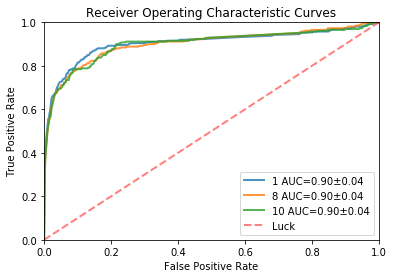


variation 3 -> learning_rate
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 400, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
8,logistic,True,"(64,)",adaptive,0.01,3,3200,sgd,9,0.898944,0.101056,0.902240
2,logistic,True,"(4,)",adaptive,0.05,3,400,sgd,9,0.826072,0.173928,0.900921
5,logistic,True,"(64,)",adaptive,0.01,3,800,sgd,9,0.891252,0.108748,0.896622
0,logistic,True,"(4,)",constant,0.05,3,400,sgd,9,0.847798,0.152202,0.895296
6,logistic,True,"(64,)",constant,0.01,3,3200,sgd,9,0.896530,0.103470,0.894870
3,logistic,True,"(64,)",constant,0.01,3,800,sgd,9,0.839652,0.160348,0.891261
4,logistic,True,"(64,)",invscaling,0.01,3,800,sgd,9,0.808149,0.191851,0.716088
7,logistic,True,"(64,)",invscaling,0.01,3,3200,sgd,9,0.660853,0.339147,0.682536
1,logistic,True,"(4,)",invscaling,0.05,3,400,sgd,9,0.620234,0.379766,0.534897


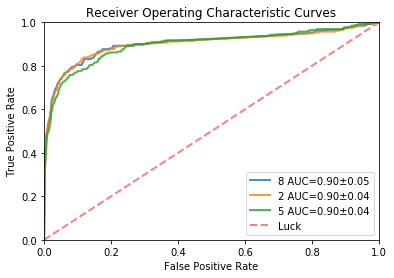


variation 4 -> activation
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 400, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
4,logistic,True,"(4,)",adaptive,0.05,3,400,sgd,9,0.854860,0.145140,0.908032
1,logistic,True,"(64,)",adaptive,0.01,3,3200,sgd,9,0.859337,0.140663,0.901269
7,logistic,True,"(64,)",adaptive,0.01,3,800,sgd,9,0.922117,0.077883,0.897929
2,tanh,True,"(64,)",adaptive,0.01,3,3200,sgd,9,0.806485,0.193515,0.896948
5,tanh,True,"(4,)",adaptive,0.05,3,400,sgd,9,0.848703,0.151297,0.894068
6,relu,True,"(64,)",adaptive,0.01,3,800,sgd,9,0.791845,0.208155,0.891947
3,relu,True,"(4,)",adaptive,0.05,3,400,sgd,9,0.868629,0.131371,0.886423
0,relu,True,"(64,)",adaptive,0.01,3,3200,sgd,9,0.811321,0.188679,0.884746
8,tanh,True,"(64,)",adaptive,0.01,3,800,sgd,9,0.836799,0.163201,0.884325


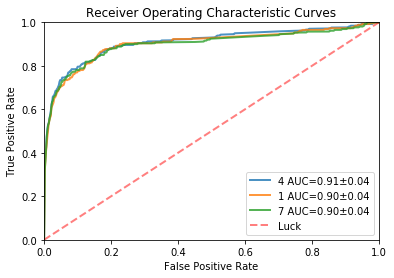


best configuration


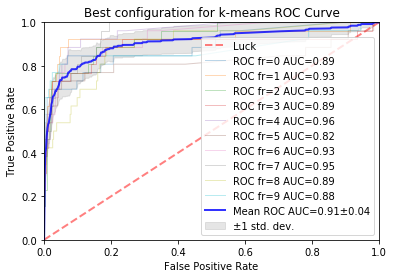

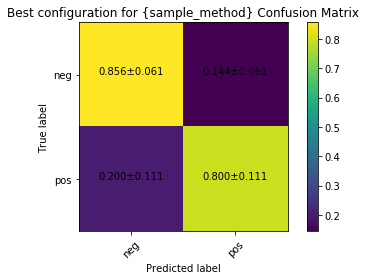

testing overfiting (increased verbose)
run 1 of 1, fold 1 of 10
run 1 of 1, fold 2 of 10
run 1 of 1, fold 3 of 10
run 1 of 1, fold 4 of 10
run 1 of 1, fold 5 of 10
run 1 of 1, fold 6 of 10
run 1 of 1, fold 7 of 10
run 1 of 1, fold 8 of 10
run 1 of 1, fold 9 of 10
run 1 of 1, fold 10 of 10


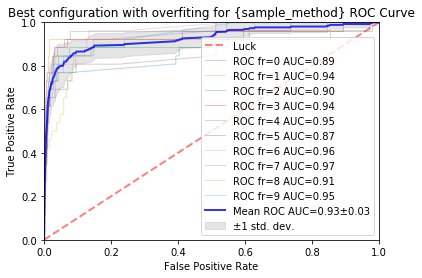

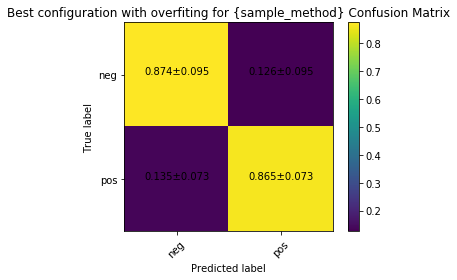




optimize model configuration for r-under with configuration range of 3
variation 0 -> learning_rate_init
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
11,logistic,True,"(16,)",adaptive,0.0500,3,800,sgd,9,0.856112,0.143888,0.915294
17,logistic,True,"(32,)",constant,0.0500,3,3200,sgd,9,0.879009,0.120991,0.909523
10,logistic,True,"(16,)",adaptive,0.0100,3,800,sgd,9,0.820515,0.179485,0.896534
16,logistic,True,"(32,)",constant,0.0100,3,3200,sgd,9,0.872478,0.127522,0.889420
9,logistic,True,"(16,)",adaptive,0.0050,3,800,sgd,9,0.710584,0.289416,0.798455
5,logistic,True,"(8,)",invscaling,0.0500,3,200,sgd,9,0.635782,0.364218,0.789256
15,logistic,True,"(32,)",constant,0.0050,3,3200,sgd,9,0.608032,0.391968,0.666652
12,logistic,True,"(32,)",constant,0.0001,3,3200,sgd,9,0.342659,0.657341,0.598753
8,logistic,True,"(16,)",adaptive,0.0010,3,800,sgd,9,0.502339,0.497661,0.588695
7,logistic,True,"(16,)",adaptive,0.0005,3,800,sgd,9,0.436401,0.563599,0.586352


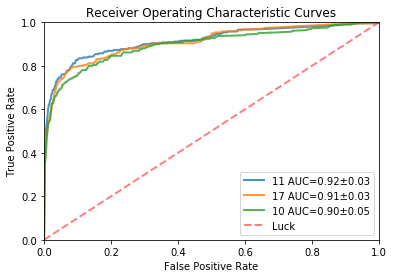


variation 1 -> hidden_layer_sizes
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
11,logistic,True,"(32,)",constant,0.05,3,3200,sgd,9,0.880973,0.119027,0.915891
5,logistic,True,"(64,)",adaptive,0.05,3,800,sgd,9,0.883655,0.116345,0.915672
4,logistic,True,"(32,)",adaptive,0.05,3,800,sgd,9,0.893403,0.106597,0.914604
20,logistic,True,"(128,)",adaptive,0.01,3,800,sgd,9,0.887050,0.112950,0.913976
12,logistic,True,"(64,)",constant,0.05,3,3200,sgd,9,0.893322,0.106678,0.911228
6,logistic,True,"(128,)",adaptive,0.05,3,800,sgd,9,0.853424,0.146576,0.909885
9,logistic,True,"(8,)",constant,0.05,3,3200,sgd,9,0.815963,0.184037,0.908767
1,logistic,True,"(4,)",adaptive,0.05,3,800,sgd,9,0.779014,0.220986,0.907575
13,logistic,True,"(128,)",constant,0.05,3,3200,sgd,9,0.847609,0.152391,0.907416
19,logistic,True,"(64,)",adaptive,0.01,3,800,sgd,9,0.873365,0.126635,0.906615


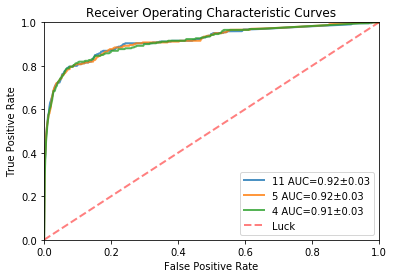


variation 2 -> max_iter
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
4,logistic,True,"(32,)",constant,0.05,3,3200,sgd,9,0.867027,0.132973,0.916374
6,logistic,True,"(64,)",adaptive,0.05,3,200,sgd,9,0.877659,0.122341,0.915868
2,logistic,True,"(32,)",constant,0.05,3,800,sgd,9,0.850400,0.149600,0.915309
1,logistic,True,"(32,)",constant,0.05,3,400,sgd,9,0.862453,0.137547,0.915068
11,logistic,True,"(64,)",adaptive,0.05,3,6400,sgd,9,0.873647,0.126353,0.914866
14,logistic,True,"(32,)",adaptive,0.05,3,800,sgd,9,0.857289,0.142711,0.914777
16,logistic,True,"(32,)",adaptive,0.05,3,3200,sgd,9,0.847346,0.152654,0.914752
5,logistic,True,"(32,)",constant,0.05,3,6400,sgd,9,0.873913,0.126087,0.914153
7,logistic,True,"(64,)",adaptive,0.05,3,400,sgd,9,0.863619,0.136381,0.913917
17,logistic,True,"(32,)",adaptive,0.05,3,6400,sgd,9,0.871045,0.128955,0.913915


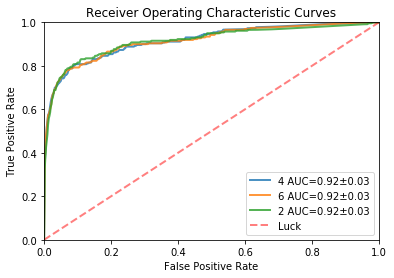


variation 3 -> learning_rate
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
0,logistic,True,"(32,)",constant,0.05,3,3200,sgd,9,0.874886,0.125114,0.914105
5,logistic,True,"(64,)",adaptive,0.05,3,200,sgd,9,0.892242,0.107758,0.913670
6,logistic,True,"(32,)",constant,0.05,3,800,sgd,9,0.861028,0.138972,0.913611
8,logistic,True,"(32,)",adaptive,0.05,3,800,sgd,9,0.866044,0.133956,0.913537
3,logistic,True,"(64,)",constant,0.05,3,200,sgd,9,0.904675,0.095325,0.910776
2,logistic,True,"(32,)",adaptive,0.05,3,3200,sgd,9,0.827491,0.172509,0.906329
4,logistic,True,"(64,)",invscaling,0.05,3,200,sgd,9,0.531296,0.468704,0.820741
1,logistic,True,"(32,)",invscaling,0.05,3,3200,sgd,9,0.740130,0.259870,0.755081
7,logistic,True,"(32,)",invscaling,0.05,3,800,sgd,9,0.566556,0.433444,0.740798


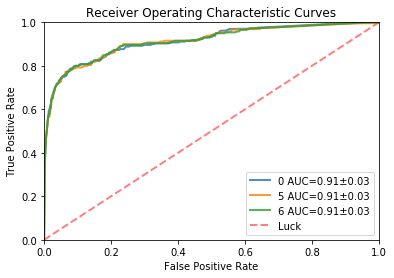


variation 4 -> activation
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
5,tanh,True,"(64,)",adaptive,0.05,3,200,sgd,9,0.854948,0.145052,0.922758
0,relu,True,"(32,)",constant,0.05,3,3200,sgd,9,0.837966,0.162034,0.918046
8,tanh,True,"(32,)",constant,0.05,3,800,sgd,9,0.818557,0.181443,0.917516
3,relu,True,"(64,)",adaptive,0.05,3,200,sgd,9,0.841006,0.158994,0.917488
4,logistic,True,"(64,)",adaptive,0.05,3,200,sgd,9,0.859604,0.140396,0.916184
6,relu,True,"(32,)",constant,0.05,3,800,sgd,9,0.810967,0.189033,0.913170
2,tanh,True,"(32,)",constant,0.05,3,3200,sgd,9,0.815509,0.184491,0.912260
1,logistic,True,"(32,)",constant,0.05,3,3200,sgd,9,0.892232,0.107768,0.910906
7,logistic,True,"(32,)",constant,0.05,3,800,sgd,9,0.890900,0.109100,0.907208


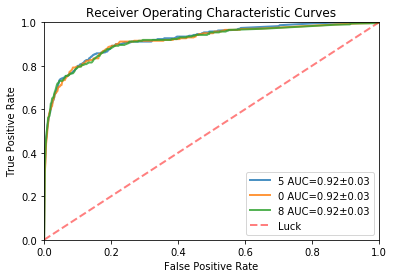


best configuration


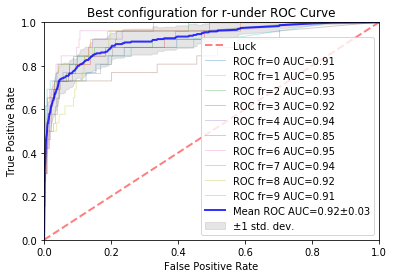

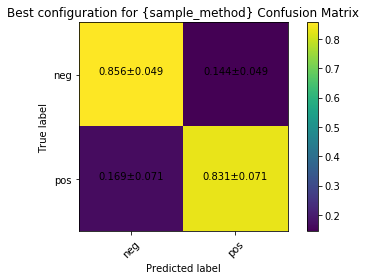

testing overfiting (increased verbose)
run 1 of 1, fold 1 of 10
run 1 of 1, fold 2 of 10
run 1 of 1, fold 3 of 10
run 1 of 1, fold 4 of 10
run 1 of 1, fold 5 of 10
run 1 of 1, fold 6 of 10
run 1 of 1, fold 7 of 10
run 1 of 1, fold 8 of 10
run 1 of 1, fold 9 of 10
run 1 of 1, fold 10 of 10


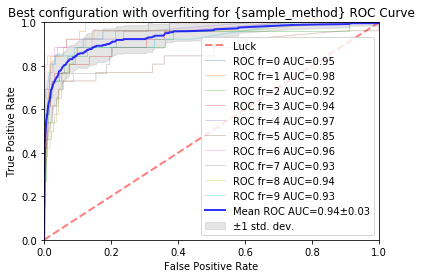

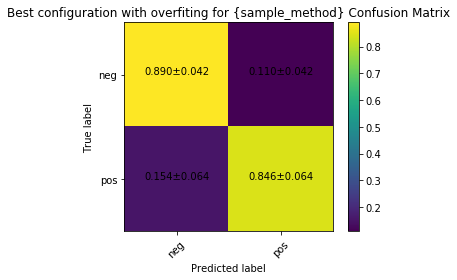

In [11]:
configuration_range = 3

for sample_method, sample_folds in samples_folds.items():
    print(f'optimize model configuration for {sample_method} with configuration range of {configuration_range}')
    configurations = base_configurations
    results = None
    for i, (variation_name, variation_values) in enumerate(variations):
        print(f'variation {i} -> {variation_name}')
        configurations_results = validate_model_configurations_variations(model_class, configurations,
                                                                          variation_name, variation_values,
                                                                          sample_folds, base_folds,
                                                                          verbose=1)

        db_frame = pd.DataFrame([configuration for configuration, result in configurations_results])
        db_frame['mean score'] = [np.mean(result['score']) for _, result in configurations_results]
        db_frame['mean mse'] = [np.mean(result['mse']) for _, result in configurations_results]
        db_frame['mean roc auc'] = [np.mean(result['roc']['auc']) for _, result in configurations_results]
        db_frame['data'] = [(c, r) for c, r in configurations_results]
        db_frame.drop_duplicates([column for column in db_frame if column != 'data'], inplace=True)

        db_frame.sort_values(by=['mean roc auc', 'mean score'], ascending=[False, False], inplace=True)
        filtered_data_frame = db_frame[[column for column in db_frame if column != 'data']]
        if NOTEBOOK:
            display(filtered_data_frame)
        else:
            print(filtered_data_frame.to_string())

        configurations = [c for c, _ in db_frame['data'][:min(configuration_range, len(db_frame['data']))]]
        results = [r for _, r in db_frame['data'][:min(configuration_range, len(db_frame['data']))]]
        plot_multi_configuration_roc_curves((r['roc'] for r in results), db_frame.index)
        print()

    print('best configuration')
    best_configuration = configurations[0]
    best_configuration_results = results[0]
    plot_single_configuration_roc_curves(best_configuration_results['roc'],
                                         title=f'Best configuration for {sample_method} ROC Curve')
    plot_single_configuration_confusion_matrix(best_configuration_results['matrix'], ['neg', 'pos'],
                                               title='Best configuration for {sample_method} Confusion Matrix')

    print('testing overfiting (increased verbose)')
    overfiting_configuration = best_configuration.copy()
    overfiting_configuration['max_fail'] = 1000
    overfiting_configuration['max_iter'] = 30000
    overfiting_configuration_results = validate_model(model_class(**overfiting_configuration), sample_folds,
                                                      base_folds, verbose=3)
    plot_single_configuration_roc_curves(overfiting_configuration_results['roc'],
                                         title='Best configuration with overfiting for {sample_method} ROC Curve')
    plot_single_configuration_confusion_matrix(overfiting_configuration_results['matrix'], ['neg', 'pos'],
                                               title='Best configuration with overfiting for {sample_method} Confusion Matrix')
    print()
    print()
    print()